# DGF-PT2
Notebook per la previsione di `time2` su griglia fissa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGF_PT2_train.csv")
test_df = pd.read_csv("data/input/DGF_PT2_test.csv")
all_df = pd.concat([train_df, test_df])

## Stima
Il primo modello che consideriamo è la stima basata sulla proporzione rispetto al modello operativo, detta previsione ottimistica (PO).

In [2]:
def optimistic_estimate(df):
    x_length = 10000
    y_length = 10000
    ni = x_length / df.grid_step
    nj = y_length / df.grid_step
    n_procs = df.n_nodes * df.n_cores
    return 59.8 * (20/df.grid_step) * (ni*nj/403776) * (864/n_procs) * (1 - 0.3*df.single_precision)

In [3]:
test_res_oe = test_df.copy()
test_res_oe["target"] = test_res_oe.time2
test_res_oe["prediction"] = optimistic_estimate(test_df)
test_res_oe["residual"] = test_res_oe.target - test_res_oe.prediction
test_res_oe["relative"] = test_res_oe.residual / test_res_oe.target
test_res_oe["abs_err"] = (test_res_oe.target - test_res_oe.prediction).abs()
test_res_oe["rel_err"] = test_res_oe.abs_err / test_res_oe.target
test_res_oe[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,7.310891,0.282955
std,11.077407,0.206869
min,0.002886,0.000507
25%,0.552337,0.117317
50%,2.554335,0.242235
75%,9.484375,0.414039
max,70.559156,0.989881


In [4]:
print("RMSE:", np.sqrt((test_res_oe.abs_err ** 2).mean()))

RMSE: 13.268442274883421


Possiamo notare come il modello sovrastimi la previsione quasi sempre.

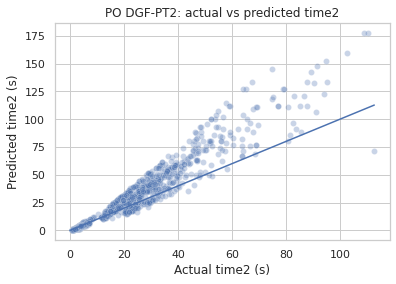

In [5]:
plt.title("PO DGF-PT2: actual vs predicted time2")
plt.plot([0, test_res_oe.target.max()], [0, test_res_oe.target.max()])
sns.scatterplot(data=test_res_oe, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgf-pt2/po-correlazione-osservazione-previsione.pdf")
plt.show()

Il grafico dei residui presenta un evidente pattern lineare: maggiore il tempo di esecuzione, maggiore la sovrastima.

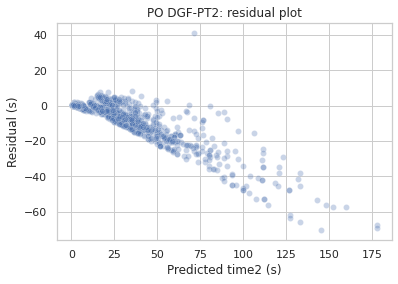

In [6]:
plt.title("PO DGF-PT2: residual plot")
sns.scatterplot(data=test_res_oe, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.show()

Il modello presenta un andamento bimodale della distribuzione dell'errore assoluto. 

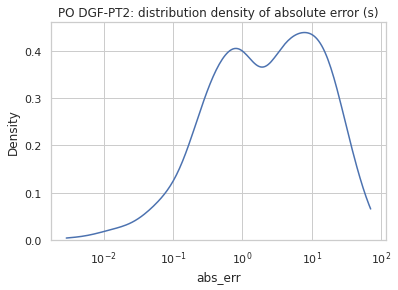

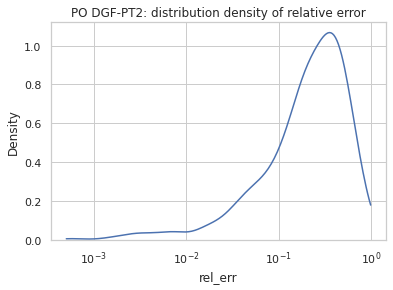

In [7]:
sns.kdeplot(data=test_res_oe, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("PO DGF-PT2: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_oe, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("PO DGF-PT2: distribution density of relative error")
plt.show()

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [8]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time2
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,3.399932,0.256743
std,5.744436,0.222110
min,0.001404,0.000056
25%,0.745218,0.063972
50%,1.687606,0.189888
75%,3.278596,0.400230
max,65.689932,0.907914


In [9]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 6.673038414637444


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

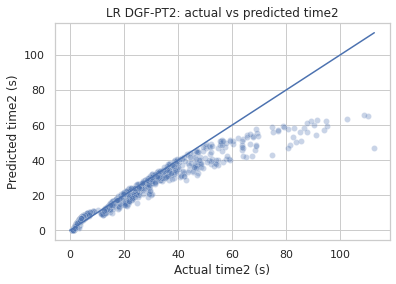

In [10]:
plt.title("LR DGF-PT2: actual vs predicted time2")
plt.plot([0, test_res_lr.target.max()], [0, test_res_lr.target.max()])
sns.scatterplot(data=test_res_lr, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgf-pt2/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

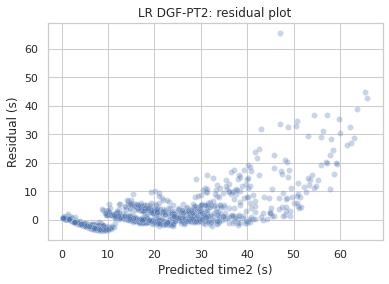

In [11]:
plt.title("LR DGF-PT2: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt2/lr-grafico-residui.pdf")
plt.show()

Si può invece notare come le distribuzioni dell'errore assoluto e realtivo abbiano un andamento unimodale e simile ad una gaussiana.

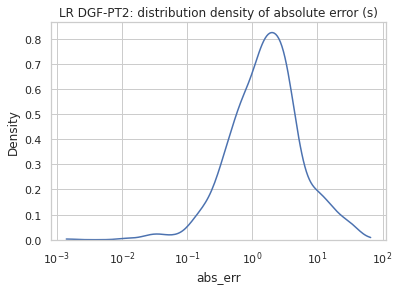

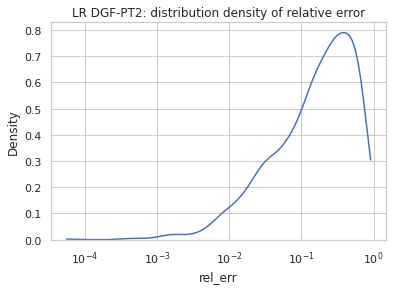

In [12]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.xscale("log")
plt.title("LR DGF-PT2: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("LR DGF-PT2: distribution density of relative error")
plt.show()

## DGF-PT2 senza HP tuning

La prima prova con un FCNN viene fatta usando due hidden layer, addestrata per 500 epoch.

In [13]:
config = {
    "batch": "full",
    "optimizer": {
        "name": "adam",
        "lr": 0.05,
        "weight_decay": 0.0
    },
    "loss": "mse",
    "model": {
        "layers": [{
            "size": 14,
            "dropout": 0.0,
        }, {
            "size": 7,
            "dropout": 0.0
        }]
    }
}
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_noopt = model.fit(data, 500)
test_res_noopt = model.test(data)

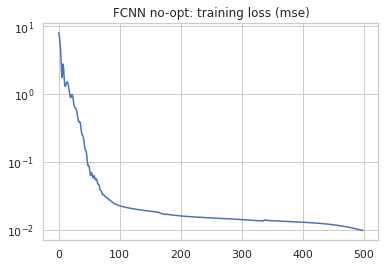

In [14]:
train_res_noopt.train_loss.plot(grid=True, logy=True)
plt.title(f"FCNN no-opt: training loss ({config['loss']})")
plt.show()

Si può notare un miglioramento rispetto al modello LR guardando il massimo e il 75° percentile dell'errore massimo e relativo.

In [15]:
test_res_noopt["abs_err"] = (test_res_noopt.target - test_res_noopt.prediction).abs()
test_res_noopt["rel_err"] = test_res_noopt.abs_err / test_res_noopt.target
test_res_noopt["residual"] = test_res_noopt.target - test_res_noopt.prediction
test_res_noopt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,1.818817,0.070666
std,3.553832,0.057867
min,0.000231,0.000135
25%,0.162355,0.029312
50%,0.583113,0.056930
75%,1.976151,0.098419
max,54.824677,0.486466


Il RMSE si è quasi dimezzato rispetto al LR.

In [16]:
print("RMSE:", np.sqrt((test_res_noopt.abs_err ** 2).mean()))

RMSE: 3.990846014082782


Lo stesso miglioramento si può apprezzare anche guardando il grafico tra tempo osservato e previsto, in cui è meno marcato il progressivo aumento dell'errore all'aumentare del tempo osservato.

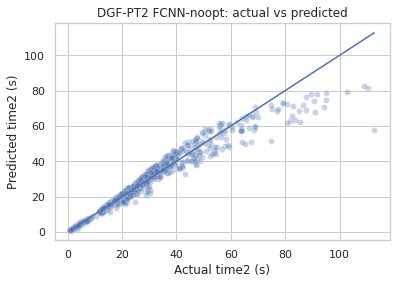

In [17]:
plt.title("DGF-PT2 FCNN-noopt: actual vs predicted")
plt.plot([test_res_noopt.target.min(), test_res_noopt.target.max()], [test_res_noopt.target.min(), test_res_noopt.target.max()])
sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.prediction, alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-noopt-correlazione-osservazione-previsione.pdf")
plt.show()

Anche il grafico dei residui rispetto al valore predetto presenta pattern meno evidenti.

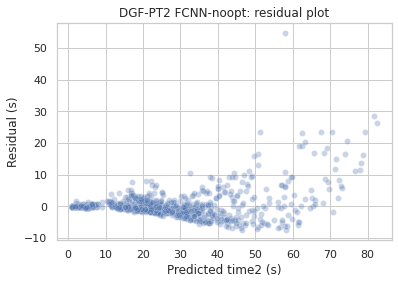

In [18]:
plt.title("DGF-PT2 FCNN-noopt: residual plot")
sns.scatterplot(data=test_res_noopt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-noopt-grafico-residui.pdf")
plt.show()

## DGF-PT2 con HP tuning
Il modello è stato sottoposto a hyperparameter tuning, effettuando 500 tentativi con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [19]:
with open("data/hpopt/DGF_PT2.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [20]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [21]:
print("Best loss", best["result"]["loss"])

Best loss 1.502315734766377


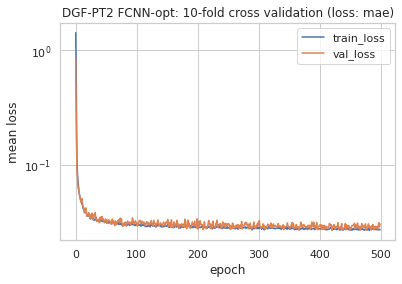

In [22]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"DGF-PT2 FCNN-opt: 10-fold cross validation (loss: {config['loss']})")
plt.ylabel("mean loss")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [23]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 420


Il modello ottimizzato ha due hidden layer con una dimensione leggermente maggiore rispetto al modello non ottimizzato e usa MAE come loss function.

In [24]:
print(yaml.dump(config))

batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 34
  - dropout: 0.0
    size: 31
optimizer:
  lr: 0.002387811870090571
  name: adam
  weight_decay: 0.040560134999093896



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [25]:
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_opt = model.fit(data, best_epoch)
test_res_opt = model.test(data)

<AxesSubplot:>

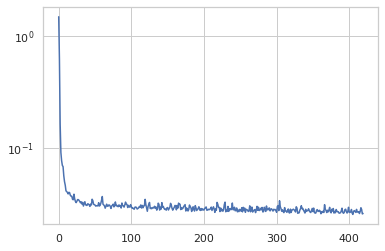

In [26]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Si nota un miglioramento sia nell'errore assoluto che relativo rispetto al modello non ottimizzato (tranne che per l'errore relativo massimo, che diminuisce di poco).

In [27]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,0.581207,0.028371
std,1.689650,0.036087
min,0.000201,0.000077
25%,0.066208,0.008794
50%,0.205294,0.020593
75%,0.647269,0.037332
max,48.719547,0.432294


Il RMSE è migliore rispetto al modello non ottimizzato e si discosta di 0.3 secondi (in più) rispetto al RMSE del cross-validation set.

In [28]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 1.7861242499674665


Possiamo notare il miglioramento, soprattutto nella previsione dei tempi più lunghi.

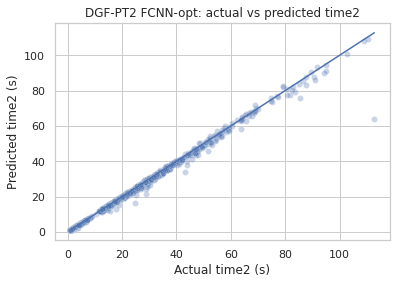

In [29]:
plt.title("DGF-PT2 FCNN-opt: actual vs predicted time2")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare una lieve eteroschedasticità

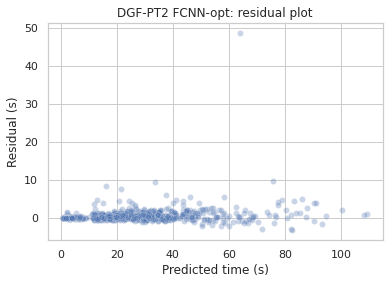

In [30]:
plt.title("DGF-PT2 FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-opt-grafico-residui.pdf")
plt.show()

Qui sotto, sono confrontati i grafici di correlazione tra errore assoluto e tempo osservato dei tre modelli. Si può notare come l'FCNN ottimizzato abbia un comportamento sensibilmente migliore rispetto agli altri due modelli nella previsione dei tempi più lunghi: tranne un singolo valore (il cui valore osservato è probabilmente frutto di un malfunzionamento, come verrà mostrato successivamente), tutti gli errori sono entro i 10 secondi.

In [31]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE PO: 7.310891318046229
MAE LR: 3.3999319890578894
MAE FCNN no-opt: 1.8188165499207873
MAE FCNN opt: 0.5812069936655462


In [32]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE PO: 13.268442274883421
RMSE LR: 6.673038414637444
RMSE FCNN no-opt: 3.990846014082782
RMSE FCNN opt: 1.7861242499674665


In [33]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE PO: 28.295451747341676
MAPE LR: 25.674309353998748
MAPE FCNN no-opt: 7.066648507389354
MAPE FCNN opt: 2.8370716546628927


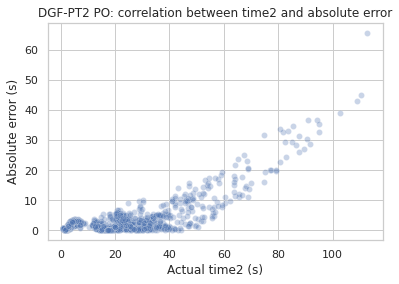

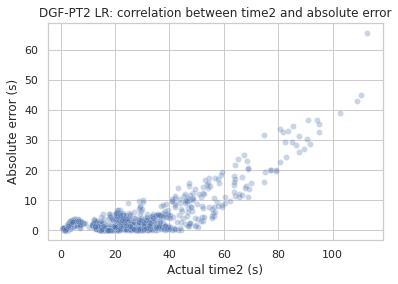

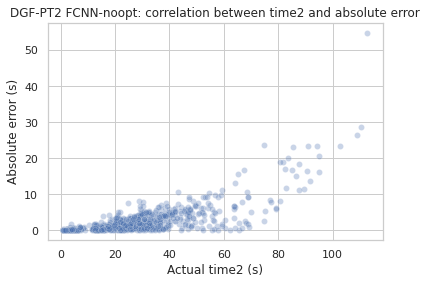

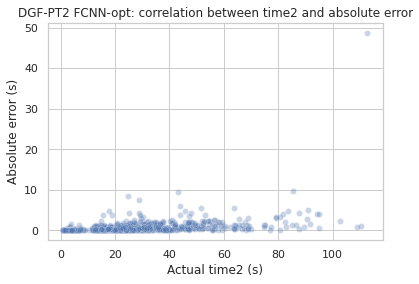

In [34]:
sns.scatterplot(x=test_res_oe.target, y=test_res_lr.abs_err, alpha=0.3)
plt.title("DGF-PT2 PO: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt2/po-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_lr.target, y=test_res_lr.abs_err, alpha=0.3)
plt.title("DGF-PT2 LR: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt2/lr-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.abs_err, alpha=0.3)
plt.title("DGF-PT2 FCNN-noopt: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-noopt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.abs_err, alpha=0.3)
plt.title("DGF-PT2 FCNN-opt: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt2/fcnn-opt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

Qui sotto vediamo invece la correlazione con l'errore relativo: si nota come nel caso di LR l'errore sia alto nel caso di tempi brevi e poi torni a salire per i tempi più lunghi. Negli altri due casi, invece, si hanno risultati peggiori nel caso dei tempi brevi (ma significativamente migliori rispetto a LR) e nell'FCNN ottimizzato non sia più presente un rapporto lineare tra errore relativo e tempo di esecuzione per i valori osservati più alti.

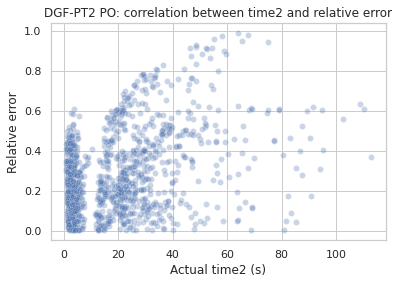

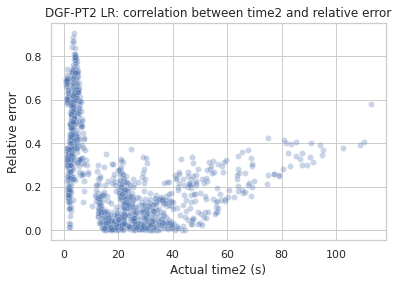

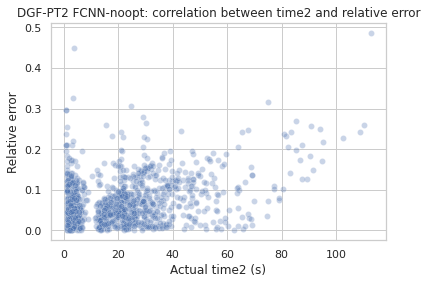

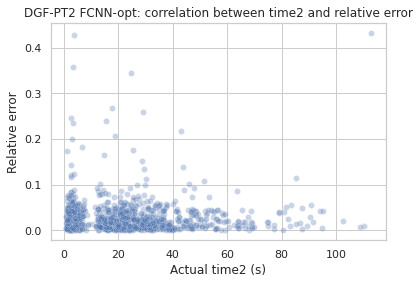

In [35]:
sns.scatterplot(x=test_res_oe.target, y=test_res_oe.rel_err, alpha=0.3)
plt.title("DGF-PT2 PO: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt2/po-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_lr.target, y=test_res_lr.rel_err, alpha=0.3)
plt.title("DGF-PT2 LR: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt2/lr-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.rel_err, alpha=0.3)
plt.title("DGF-PT2 FCNN-noopt: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt2/fcnn-noopt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.rel_err, alpha=0.3)
plt.title("DGF-PT2 FCNN-opt: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt2/fcnn-opt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo nei tre modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, i modelli FCNN sono migliori di PO e LR (in particolar modo per quanto riguarda l'errore relativo) e il modello ottimizzato è sensibilmente migliore di quello non ottimizzato.

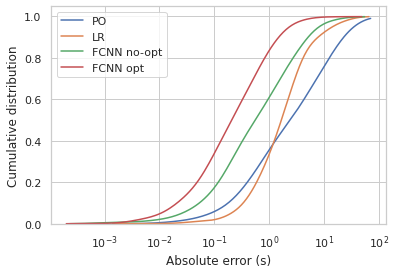

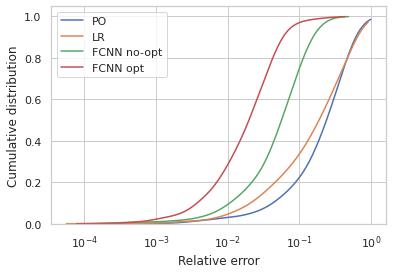

In [36]:
sns.kdeplot(data=test_res_oe, x="abs_err", log_scale=True, cumulative=True, cut=0, label="PO")
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pt2/cdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_oe, x="rel_err", log_scale=True, cumulative=True, cut=0, label="PO")
sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.legend()
plt.savefig("tex/images/dgf-pt2/cdf-errore-relativo.pdf")
plt.show()

Nel caso della funzione di distribuzione dell'errore assoluto notiamo come FCNN ottimizzato non sia perfettamente monomodale.

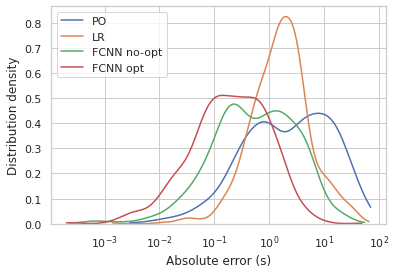

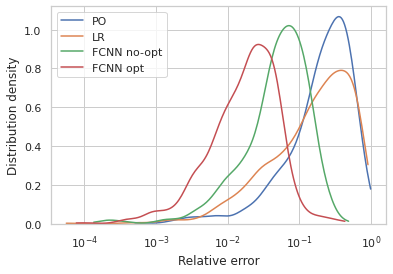

In [37]:
sns.kdeplot(data=test_res_oe, x="abs_err", log_scale=True, cumulative=False, cut=0, label="PO")
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pt2/pdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_oe, x="rel_err", log_scale=True, cumulative=False, cut=0, label="PO")
sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgf-pt2/pdf-errore-relativo.pdf")
plt.show()

Qui sotto, si riportano i grafici dei tre modelli che mostrano il rapporto tra osservato e previsto, in modo da poterli confrontare più facilmente.

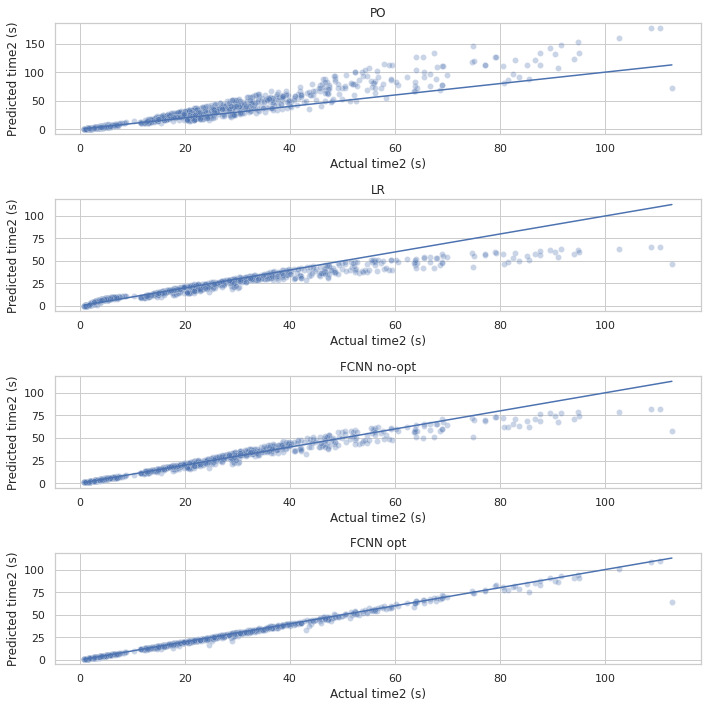

In [38]:
figure, axs = plt.subplots(4, figsize=(10, 10))

for ax, name, df in zip(axs, ("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    ax.set_title(f"{name}")
    ax.set_xlabel("Actual time2 (s)")
    ax.set_ylabel("Predicted time2 (s)")
    ax.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3, ax=ax)
    
figure.tight_layout()
plt.show()

## Conclusioni

Si può affermare che, nonostante la distribuzione dell'errore assoluto non sia esattamente una gaussiana e il grafico dei residui rispetto ai valori predetti presenti una lieve eteroschedasticità, le prestazioni del modello sono soddisfacenti:
* l'errore assoluto è dentro i 10 secondi tranne che per un task che ha avuto malfunzionamenti (vedi sotto).
* l'errore assoluto è minore di ~4.7 secondi nel 99% dei casi
* l'errore relativo è minore di ~11% nel 98% dei casi

In [39]:
pd.concat([test_df, test_res_opt], axis=1).sort_values("abs_err").tail()

,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time2,target,prediction,abs_err,rel_err,residual
0,20,57,22,0,3.714286,28.97,28.969997,21.469969,7.500029,0.258890,7.500029
486,20,37,36,1,1.000000,24.68,24.679998,16.165600,8.514399,0.344992,8.514399
1128,20,46,14,0,3.500000,43.09,43.089996,33.673729,9.416267,0.218526,9.416267
19,20,12,30,0,1.080000,85.43,85.429985,75.695938,9.734047,0.113942,9.734047
403,20,14,32,0,1.823529,112.70,112.700020,63.980473,48.719547,0.432294,48.719547


In [40]:
pd.concat([test_df, test_res_opt], axis=1).query("time2 >= 30").sort_values("rel_err").tail()

,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time2,target,prediction,abs_err,rel_err,residual
441,20,60,14,0,1.916667,30.10,30.100002,26.695969,3.404034,0.113091,3.404034
19,20,12,30,0,1.080000,85.43,85.429985,75.695938,9.734047,0.113942,9.734047
997,20,25,36,0,1.538462,43.69,43.689999,37.618420,6.071579,0.138970,6.071579
1128,20,46,14,0,3.500000,43.09,43.089996,33.673729,9.416267,0.218526,9.416267
403,20,14,32,0,1.823529,112.70,112.700020,63.980473,48.719547,0.432294,48.719547


In [41]:
test_res_opt[["abs_err", "rel_err"]].quantile([0.9, 0.95, 0.98, 0.99], interpolation="higher")

,abs_err,rel_err
0.90,1.369703,0.054359
0.95,2.079620,0.073000
0.98,3.723022,0.113942
0.99,4.694656,0.199468


L'outlier nelle previsioni corrisponde ad un outlier tra le osservazioni (probabilmente dovuto ad un malfunzionamento). Qui sotto possiamo notare come abbia un valore molto distante rispetto a esecuzioni del modello con parametri uguali. Lo stesso task è stato individuato come malfunzionante nell'analisi di DGF-PT2.

In [42]:
outlier = test_df.iloc[test_res_opt.abs_err.idxmax()]
print("Indice dell'outlier:", outlier.name)
test_df.query((
    "grid_step == @outlier.grid_step and "
    "n_nodes >= (@outlier.n_nodes - 2) and n_nodes <= (@outlier.n_nodes + 2) and "
    "n_cores == @outlier.n_cores and "
    "single_precision == @outlier.single_precision"
)).sort_values("time2")

Indice dell'outlier: 403


,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time2
677,20,14,32,0,2.333333,64.20
274,20,13,32,0,2.533333,68.95
847,20,13,32,0,1.631579,69.03
403,20,14,32,0,1.823529,112.70
